## Tree Detection with DeepForest

This jupyter notebook uses the python library DeepForest to identify and put bounding boxes around trees. 

If using the software, please cite as: 
Geographic Generalization in Airborne RGB Deep Learning Tree Detection Ben. G. Weinstein, Sergio Marconi, Stephanie A. Bohlman, Alina Zare, Ethan P. White bioRxiv 790071; doi: https://doi.org/10.1101/790071

In [1]:
#Install the deepforest python library. After installing, you may need to restart the kernel before moving to the next code snippet
!pip install DeepForest --quiet

In [2]:
##After restarting the kernel, import libraries into environment...
from deepforest import main
from deepforest import get_data
from deepforest.utilities import boxes_to_shapefile
from deepforest.utilities import shapefile_to_annotations
from deepforest.preprocess import split_raster

import matplotlib.pyplot as plt
import os
import time
import numpy

In [3]:
#Bring a DeepForest pretrained model into environment
model = main.deepforest()
model.use_release()

Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /home/jovyan/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|██████████| 130M/130M [00:01<00:00, 112MB/s]  
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


No validation file provided. Turning off validation loop


/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


NEON.pt: 129MB [00:02, 47.6MB/s]                              


Model was downloaded and saved to /opt/conda/lib/python3.11/site-packages/deepforest/data/NEON.pt
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


## Predict Tree Crowns on Raw (non-georeferenced images)

In [4]:
#Path for the image you want to ID trees. These are non-georeferenced single jpeg drone image. In this example, the image data is in Cyverse
image_path = get_data("/data-store/iplant/home/shared/commons_repo/curated/Gillan_Ecosphere_2021/raw_images/May_2019/15-g2/100_0123/100_0123_0086.JPG")
image_path2 = get_data("/data-store/iplant/home/jgillan/media/DJI_0184.jpeg")
image_path3 = get_data("/data-store/iplant/home/jgillan/media/100_0407_0064.jpeg")
image_path4 = get_data("/data-store/iplant/home/jgillan/media/DJI_0468.jpeg")
image_path5 = get_data("/data-store/iplant/home/jgillan/media/101_0472_0074.jpeg")

In [35]:
#Identify and put bounding boxes around all trees in the image
#This will create a table showing image coordinates of every predicted tree
#The 'score' is the confidence that the prediction is correct. Values closer to 1 are better. 
trees = model.predict_image(path=image_path5, return_plot = False)
trees

,xmin,ymin,xmax,ymax,label,score,image_path
0,356.0,299.0,381.0,325.0,Tree,0.570020,101_0472_0074.jpeg
1,359.0,256.0,390.0,285.0,Tree,0.529568,101_0472_0074.jpeg
2,524.0,428.0,555.0,457.0,Tree,0.480388,101_0472_0074.jpeg
3,133.0,97.0,165.0,127.0,Tree,0.477637,101_0472_0074.jpeg
4,222.0,0.0,249.0,9.0,Tree,0.453819,101_0472_0074.jpeg
...,...,...,...,...,...,...,...
68,184.0,136.0,216.0,171.0,Tree,0.160450,101_0472_0074.jpeg
69,416.0,123.0,449.0,161.0,Tree,0.156768,101_0472_0074.jpeg
70,555.0,114.0,593.0,157.0,Tree,0.154577,101_0472_0074.jpeg
71,229.0,368.0,265.0,405.0,Tree,0.153978,101_0472_0074.jpeg


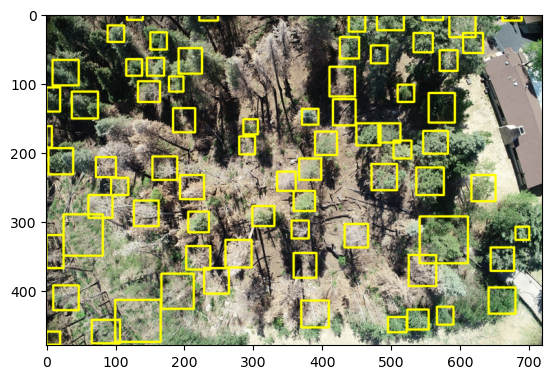

In [36]:
#Show the image with the bounding boxes
plot = model.predict_image(path=image_path5, return_plot = True, color=(0, 255, 255), thickness=2)
plt.imshow(plot[:,:,::-1])

## Predict Tree Crowns on Georeferenced Images

In [ ]:
#Set the path for a georeferenced image you want to predict tree crowns
raster_path = get_data("/data-store/iplant/home/jgillan/media/1a_g2_ortho.tif")

In [ ]:
##Predict tree crowns on a georeferenced image
predicted_raster = model.predict_tile(raster_path, return_plot = True, patch_size=1000, patch_overlap=0.25, color=(0, 255, 255), thickness=3)

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(predicted_raster)
plt.show()

## Improve Model with Training
If the pre-trained model does not identify all trees, then we want to improve the model by adding some training data and fine-tuning the model.
Manual labeling of trees (bounding boxes) can be done in QGIS. The output should be a polygon shapefile (.shp). Instructions for using QGIS is [here](https://github.com/ua-datalab/Geospatial_Workshops/wiki/Drone-Image-Analysis-%E2%80%90-Deep-Forest)

In [7]:
##Convert Georeferenced Training Data (shapefile) to annotation that can be ingested by DeepForest
#Define data paths in preparation to convert .shp to annotation dataframe that can be used for training

# training data imagery path
train_image_path = get_data("/data-store/iplant/home/jgillan/media/1a_g2_ortho.tif")

# the directory that has the training data imagery
train_image_dir = os.path.dirname(train_image_path)

# the name of the training imagery
image_name = os.path.basename(train_image_path)

# shapefile path
shp_path = "/data-store/iplant/home/jgillan/media/srer_train.shp"

# Location where you will save the annotation dataframe
savedir = "/data-store/iplant/home/jgillan/media"

In [8]:
##Convert .shp to annoation
df = shapefile_to_annotations(shapefile=shp_path, rgb=train_image_path, geometry_type='bbox', savedir=savedir)

In [9]:
#Show the annotation
df

,image_path,xmin,ymin,xmax,ymax,label
0,1a_g2_ortho.tif,7015,5049,7613,5638,Tree
1,1a_g2_ortho.tif,6647,5597,7360,6297,Tree
2,1a_g2_ortho.tif,7338,6157,7734,6436,Tree
3,1a_g2_ortho.tif,7661,5977,8035,6303,Tree
4,1a_g2_ortho.tif,7211,6404,7775,6968,Tree
...,...,...,...,...,...,...
145,1a_g2_ortho.tif,1009,8152,1572,8539,Tree
146,1a_g2_ortho.tif,2503,8007,2776,8349,Tree
147,1a_g2_ortho.tif,2833,7829,3447,8304,Tree
148,1a_g2_ortho.tif,2845,7221,3397,7855,Tree


In [10]:
#Write training data dataframe to csv file
df.to_csv(os.path.join(train_image_dir, "train_example.csv"), index=False)

In [31]:
##This will split a large georeferenced image (and it's labels) into smaller pieces. This prevents running out of memory.
annotation_path = os.path.join(train_image_dir, "train_example.csv")

#create a directory where the smaller images will be stored
crop_dir = os.path.join(train_image_dir, 'train_data_folder_test')

# Do the split and write out the cropped images as .png files. 
#Also write a new annotation table (csv) that lists all of the label coordinates and the cropped image they belong to. 
output_crops = split_raster(path_to_raster=train_image_path,
                            annotations_file=annotation_path,
                            base_dir=crop_dir,
                            patch_size=1100,  #1100x1100 pixels
                            patch_overlap=0.25, #cropped image overlap. This is useful because label boxes may be on the edge of cropped images.
                            allow_empty=False)

print(f"Number of tree crown annotations: {len(output_crops)}")
output_crops

Number of tree crown annotations: 144


In [15]:
#Create a variable that defines the path of new annotation table
base_name, _ = os.path.splitext(image_name)
csv_name = base_name + ".csv"
annotation_table = os.path.join(crop_dir, csv_name)

'/data-store/iplant/home/jgillan/media/train_data_folder/1a_g2_ortho.csv'

### Split annotation data into training and validation

In [33]:
#identify all of the cropped images as an array
image_paths = output_crops.image_path.unique()

#Of the unique cropped image paths, randomly select 25% of them
validation_paths = numpy.random.choice(image_paths, int(len(image_paths)*0.25))

#Get the individual tree annotation from the 25% cropped images
validation_annotations = output_crops.loc[output_crops.image_path.isin(validation_paths)]

#Get the individual tree annotations from the remaining 75% cropped images
train_annotations = output_crops.loc[~output_crops.image_path.isin(validation_paths)]

#Print out the number of training and testing tree crown annotations
train_annotations.head()
print("There are {} training crown annotations".format(train_annotations.shape[0]))
print("There are {} test crown annotations".format(validation_annotations.shape[0]))

There are 113 training crown annotations
There are 31 test crown annotations


In [34]:
## Write training and validation annotations to separate csv files

#save to file and create the file dir
training_file= os.path.join(crop_dir,"train.csv")
validation_file= os.path.join(crop_dir,"valid.csv")
#Write window annotations file without a header row, same location as the "base_dir" above.
train_annotations.to_csv(training_file,index=False)
validation_annotations.to_csv(validation_file,index=False)

In [ ]:
## Train 

In [37]:
##Set parameters for the training run

#Define the pre-trained model
model = main.deepforest()


#model.config["save-snapshot"] = False
#model.config["train"]["fast_dev_run"] = True

#The annotation table
model.config["train"]["csv_file"] = training_file
#The directory where the training imagery is located
model.config["train"]["root_dir"] = os.path.dirname(training_file)

model.config["score_thresh"] = 0.4
model.config["train"]['epochs'] = 2

model.config["validation"]["csv_file"] = validation_file
model.config["validation"]["root_dir"] = os.path.dirname(validation_file)


model.create_trainer()

model.use_release()


Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


No validation file provided. Turning off validation loop
Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


In [38]:
##TRAIN THE MODEL!
start_time = time.time()
model.trainer.fit(model)
print(f"--- Training on CPU: {(time.time() - start_time):.2f} seconds ---")

Missing logger folder: /home/jovyan/data-store/Geospatial_Workshops/notebooks/lightning_logs
/opt/conda/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

  | Name       | Type                  | Params
-----------------------------------------------------
0 | model      | RetinaNet             | 32.1 M
1 | iou_metric | IntersectionOverUnion | 0     
2 | mAP_metric | MeanAveragePrecision  | 0     
-----------------------------------------------------
31.9 M    Trainable params
222 K     Non-trainable params
32.1 M    Total params
128.592   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.11/site-packages/albumentations/core/composition.py:144: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/opt/conda/lib/python3.11/site-packages/deepforest/evaluate.py:193: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To ret

No predictions made


/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


--- Training on CPU: 156.52 seconds ---


In [39]:
save_dir = os.path.join(train_image_dir, 'pred_result')
os.makedirs(save_dir, exist_ok=True)
results = model.evaluate(training_file, os.path.dirname(training_file), iou_threshold = 0.4, savedir= save_dir)

/opt/conda/lib/python3.11/site-packages/albumentations/core/composition.py:144: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [43]:
save_dir = os.path.join(train_image_dir, 'valid_result')
os.makedirs(save_dir, exist_ok=True)
results = model.evaluate(validation_file, os.path.dirname(validation_file), iou_threshold = 0.4, savedir= save_dir)

/opt/conda/lib/python3.11/site-packages/albumentations/core/composition.py:144: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [44]:
results['results']

,prediction_id,truth_id,IoU,score,xmin,xmax,ymin,ymax,predicted_label,true_label,image_path,match
0,2,0,0.087261,0.184673,584,755,43,214,Tree,Tree,1a_g2_ortho_137.png,False
0,1,0,0.018706,0.184374,676,796,501,624,Tree,Tree,1a_g2_ortho_140.png,False
0,1,0,0.381710,0.180044,673,1047,743,1088,Tree,Tree,1a_g2_ortho_154.png,False
1,3,1,0.115177,0.178461,328,651,205,496,Tree,Tree,1a_g2_ortho_154.png,False
2,0,2,0.476554,0.180372,125,451,712,962,Tree,Tree,1a_g2_ortho_154.png,True
0,3,0,0.400244,0.173625,627,960,21,331,Tree,Tree,1a_g2_ortho_162.png,True
0,1,0,0.096900,0.193294,294,583,143,466,Tree,Tree,1a_g2_ortho_178.png,False
0,2,0,0.287533,0.180799,28,636,406,884,Tree,Tree,1a_g2_ortho_180.png,False
1,0,1,0.017406,0.186284,652,738,574,659,Tree,Tree,1a_g2_ortho_180.png,False
0,7,0,0.220993,0.127024,271,629,425,814,Tree,Tree,1a_g2_ortho_182.png,False
